In [1]:
#Import all the libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2023-10-11 23:17:14.345531: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 23:17:14.373913: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 23:17:14.603179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 23:17:14.604602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 23:17:16.245891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Defining path of images, image size, and batch size

data_dir = pathlib.Path('./images/').with_suffix('')
test_dir = pathlib.Path('./images_test/').with_suffix('')
batch_size = 32
img_height = 227
img_width = 227



In [8]:
# Split the data into training and validation set using 80-20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),  # No need for validation_split for test dataset
  batch_size=batch_size)


Found 5013 files belonging to 5 classes.
Using 4011 files for training.
Found 5013 files belonging to 5 classes.
Using 1002 files for validation.
Found 500 files belonging to 5 classes.


In [9]:
# Settings to improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Building the CNN architecture

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale the rgb value to [0, 1]
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)


Epoch 1/10


/home/harsh/Desktop/ml-project/venv/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


126/126 [==============================] - 53s 409ms/step - loss: 1.4917 - accuracy: 0.3453 - val_loss: 1.2026 - val_accuracy: 0.5399
Epoch 2/10
126/126 [==============================] - 52s 416ms/step - loss: 1.1078 - accuracy: 0.5532 - val_loss: 0.9435 - val_accuracy: 0.6377
Epoch 3/10
126/126 [==============================] - 54s 429ms/step - loss: 0.8258 - accuracy: 0.6761 - val_loss: 0.9137 - val_accuracy: 0.6507
Epoch 4/10
126/126 [==============================] - 53s 424ms/step - loss: 0.6838 - accuracy: 0.7337 - val_loss: 0.9066 - val_accuracy: 0.6737
Epoch 5/10
126/126 [==============================] - 52s 416ms/step - loss: 0.5532 - accuracy: 0.7846 - val_loss: 0.7707 - val_accuracy: 0.7445
Epoch 6/10
126/126 [==============================] - 52s 415ms/step - loss: 0.4442 - accuracy: 0.8369 - val_loss: 0.7778 - val_accuracy: 0.7515
Epoch 7/10
126/126 [==============================] - 53s 421ms/step - loss: 0.3461 - accuracy: 0.8761 - val_loss: 0.8340 - val_accuracy: 0.7

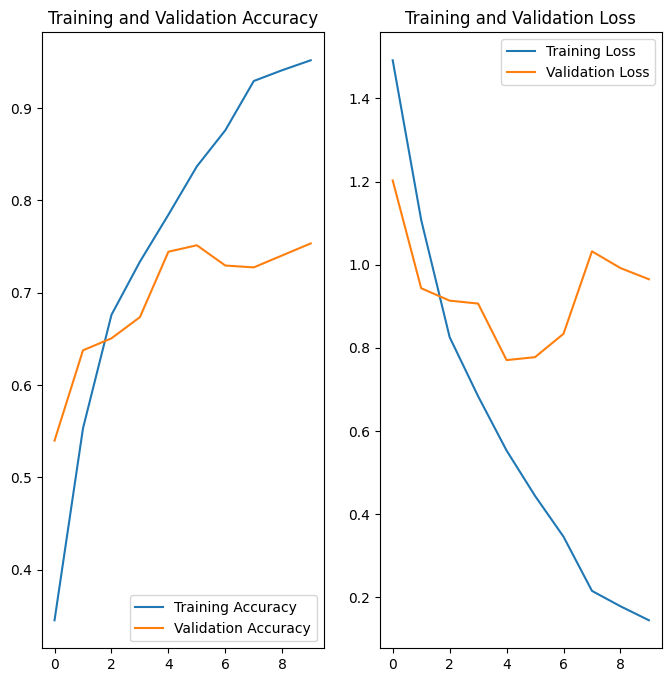

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
# The data suffers from overfitting which can clearly bee seen from the graphs above. 
# This can be solved by using 
# Data Augmentation (making new images from the given images by transforming them), and
#Dropout(Randomly dropping out some units)

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.05),
  ]
)


In [15]:
# Adding dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.05),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, name="outputs", activation='softmax')
])


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)



Epoch 1/20
126/126 [==============================] - 45s 354ms/step - loss: 1.4914 - accuracy: 0.3772 - val_loss: 1.0381 - val_accuracy: 0.6158
Epoch 2/20
126/126 [==============================] - 46s 361ms/step - loss: 1.0303 - accuracy: 0.5921 - val_loss: 0.9374 - val_accuracy: 0.6457
Epoch 3/20
126/126 [==============================] - 46s 366ms/step - loss: 0.8509 - accuracy: 0.6647 - val_loss: 0.8846 - val_accuracy: 0.6267
Epoch 4/20
126/126 [==============================] - 46s 367ms/step - loss: 0.7572 - accuracy: 0.6996 - val_loss: 0.6605 - val_accuracy: 0.7565
Epoch 5/20
126/126 [==============================] - 46s 364ms/step - loss: 0.7138 - accuracy: 0.7190 - val_loss: 0.6618 - val_accuracy: 0.7455
Epoch 6/20
126/126 [==============================] - 46s 362ms/step - loss: 0.6593 - accuracy: 0.7507 - val_loss: 0.5850 - val_accuracy: 0.7715
Epoch 7/20
126/126 [==============================] - 47s 369ms/step - loss: 0.6310 - accuracy: 0.7504 - val_loss: 0.5638 - val_ac

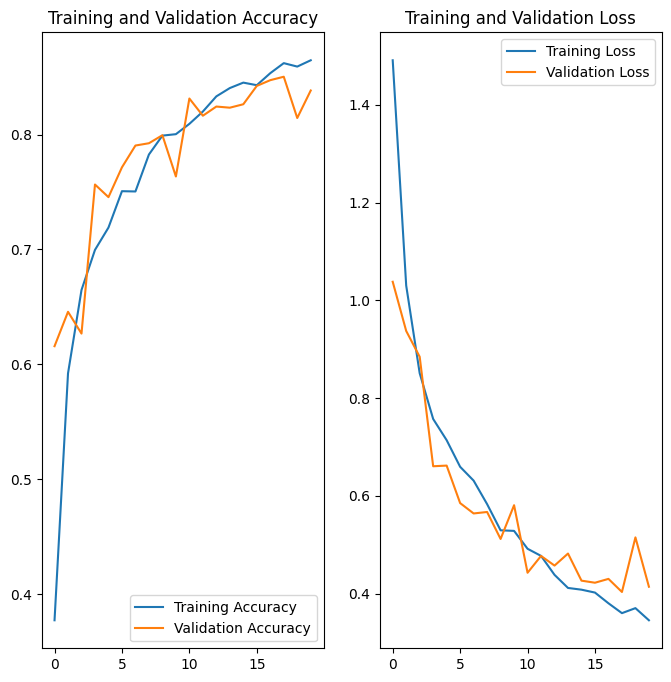

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
results = model.evaluate(test_ds)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

32/32 [==============================] - 2s 69ms/step - loss: 0.4138 - accuracy: 0.8383
Test loss: 0.4138472378253937
Test accuracy: 0.8383233547210693
